<a href="https://colab.research.google.com/github/rahuldave/LearningJax/blob/main/Jax_apps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.270
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.54
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [1]:
USE_TPU = True

if USE_TPU:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  # x8 cpu devices  
  import os
  os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

In [2]:
import jax.numpy as jnp

def sigmoid(x):
    return 1./(1. + jnp.exp(-x))

def f(params, x):
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]
    b1 = params[30]
    x = sigmoid(x*w0 + b0)
    x = sigmoid(jnp.sum(x*w1) + b1)
    return x

In [3]:
from jax import random

key = random.PRNGKey(0)
params = random.normal(key, shape=(31,))

In [4]:
from jax import grad

dfdx = grad(f, 1)

In [6]:
inputs = jnp.linspace(-2., 2., num=401)

In [7]:
from jax import vmap

f_vect = vmap(f, (None, 0))
dfdx_vect = vmap(dfdx, (None, 0))

In [11]:
from jax import jit

@jit
def loss(params, inputs):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs)
    ic = f(params, 0.) - 1.
    return jnp.mean(eq**2) + ic**2

In [12]:
grad_loss = jit(grad(loss, 0))

In [13]:
epochs = 1000
learning_rate = 0.1
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 0.954728
epoch: 100 loss: 0.061131
epoch: 200 loss: 0.024127
epoch: 300 loss: 0.008868
epoch: 400 loss: 0.003202
epoch: 500 loss: 0.001567
epoch: 600 loss: 0.000880
epoch: 700 loss: 0.000505
epoch: 800 loss: 0.000306
epoch: 900 loss: 0.000224


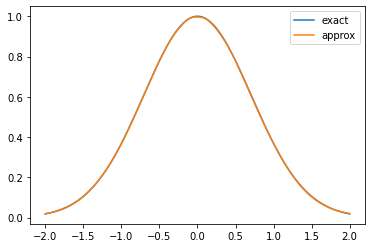

In [16]:
import matplotlib.pyplot as plt

plt.plot(inputs, jnp.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

In [17]:
import numpy as np
import pandas as pd
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import jax
import jax.numpy as jnp
from tqdm.notebook import tqdm
import plotly.express as px
from functools import partial
from typing import Callable

In [18]:
def jax_sle_loss(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate the Squared Log Error loss."""
    return (1/2 * (jnp.log1p(y_pred) - jnp.log1p(y_true))**2)

def hvp(f, inputs, vectors):
    """Hessian-vector product."""
    return jax.jvp(jax.grad(f), inputs, vectors)[1]

def jax_autodiff_grad_hess(
    loss_function: Callable[[np.ndarray, np.ndarray], np.ndarray],
    y_true: np.ndarray, y_pred: np.ndarray
):
    """Perform automatic differentiation to get the
    Gradient and the Hessian of `loss_function`."""
    loss_function_sum = lambda y_pred: loss_function(y_true, y_pred).sum()

    grad_fn = jax.grad(loss_function_sum)
    grad = grad_fn(y_pred)

    hess = hvp(loss_function_sum, (y_pred,), (jnp.ones_like(y_pred), ))

    return grad, hess

In [19]:
X, y = sklearn.datasets.fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.05, random_state=0)
print(f"Train Data: {X_train.shape[0]} examples, {X_train.shape[1]} features")

Train Data: 1032 examples, 8 features


In [21]:
jax_objective = jax.jit(partial(jax_autodiff_grad_hess, jax_sle_loss))
reg = XGBRegressor(objective=jax_objective, n_estimators=100)
reg.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=True)

[23:12:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.89628
[1]	validation_0-rmse:1.84526
[2]	validation_0-rmse:1.79421
[3]	validation_0-rmse:1.74338
[4]	validation_0-rmse:1.69287
[5]	validation_0-rmse:1.64275
[6]	validation_0-rmse:1.59351
[7]	validation_0-rmse:1.54489
[8]	validation_0-rmse:1.49703
[9]	validation_0-rmse:1.45083
[10]	validation_0-rmse:1.4057
[11]	validation_0-rmse:1.36191
[12]	validation_0-rmse:1.3194
[13]	validation_0-rmse:1.27866
[14]	validation_0-rmse:1.23975
[15]	validation_0-rmse:1.20226
[16]	validation_0-rmse:1.16705
[17]	validation_0-rmse:1.13362
[18]	validation_0-rmse:1.10209
[19]	validation_0-rmse:1.0719
[20]	validation_0-rmse:1.04363
[21]	validation_0-rmse:1.01775
[22]	validation_0-rmse:0.993392
[23]	validation_0-rmse:0.970316
[24]	validation_0-rmse:0.948399
[25]	validation_0-rmse:0.929888
[26]	validation_0-rmse:0.910925
[27]	validation_0-rmse:0.894401
[28]	validat

XGBRegressor(objective=<CompiledFunction of functools.partial(<function jax_autodiff_grad_hess at 0x7ff8ce1c8b00>, <function jax_sle_loss at 0x7ff8bcbfbe60>)>)